In [1]:
from base_dataset import BaseDataset, MattingTransform
from images_dataset import ImagesDataset

from torchvision import transforms
import numpy as np
from PIL import Image
import cv2

/home/ubuntu/miniconda3/envs/hrnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# torch_transforms = transforms.Compose(
#     [
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#     ]
# )

# ds = ImagesDataset("/home/ubuntu/data/workspace/deeplabv3_plus/people_segmentation", transform=torch_transforms)

In [3]:

train_transform = MattingTransform()
root_dir = '/home/ubuntu/data/workspace/deeplabv3_plus/people_segmentation'
ds = BaseDataset(root_dir, image_dir="images", mask_dir="masks", transform=train_transform)
# ds = BaseDataset("/home/ubuntu/data/yong/projects/P3M/data/P3M-10k/train", image_dir= "blurred_image", mask_dir="mask", transform=train_transform)
# ds = BaseDataset(root_dir)

5678


In [20]:
sample = ds[10]

In [21]:
fn, img, trimap, mask = sample

In [22]:
img.shape, mask.shape, trimap.shape

(torch.Size([3, 512, 512]),
 torch.Size([1, 512, 512]),
 torch.Size([1, 512, 512]))

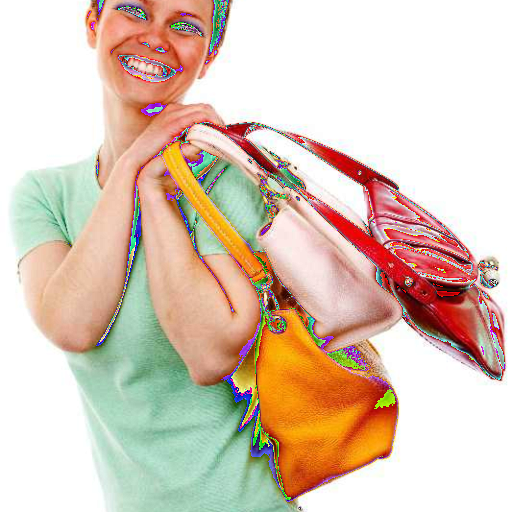

In [23]:
Image.fromarray(np.array(np.squeeze(np.transpose(img, (1, 2, 0))).numpy() * 255.0, dtype=np.uint8))

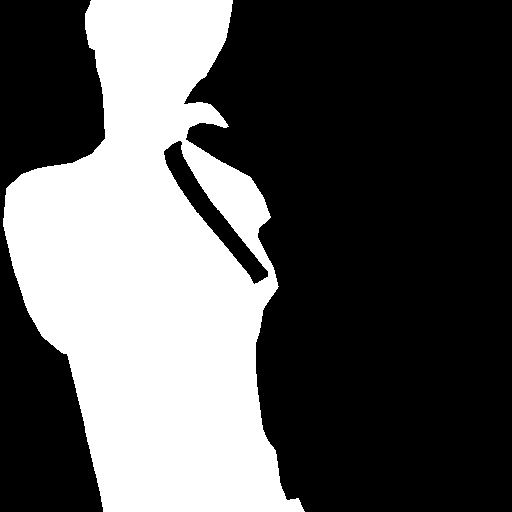

In [24]:
Image.fromarray(np.array(np.squeeze(np.transpose(mask, (1, 2, 0))).numpy() * 255.0, dtype=np.uint8))

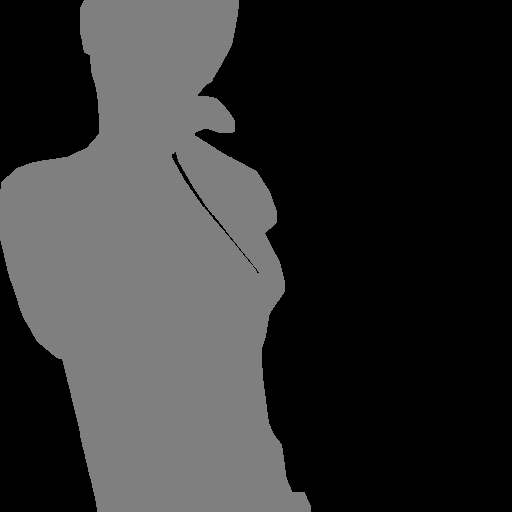

In [25]:
Image.fromarray(np.array(np.squeeze(np.transpose(trimap, (1, 2, 0))).numpy() * 255.0, dtype=np.uint8))

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from scipy.ndimage import morphology
import numpy as np
from PIL import Image
import cv2

In [ ]:
torch_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [ ]:
fn, img, trimap, alpha = sample

In [ ]:
img.shape

In [ ]:
trimap.shape

In [ ]:
alpha.shape